In [1]:
from __future__ import division
import os
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.generic_utils import get_custom_objects

import pandas as pd

from ops import *
from utils import *


Using TensorFlow backend.


In [2]:
class MNIST_PINE(object):
    model_name = "MNIST_PINE"     # name for checkpoint

    def __init__(self, sess, epoch, batch_size, dataset_name, checkpoint_dir):
        self.sess = sess
        self.dataset_name = dataset_name
        self.checkpoint_dir = checkpoint_dir
        self.epoch = epoch
        self.batch_size = batch_size

        if dataset_name == 'mnist':
            # parameters
            self.input_height = 28
            self.input_width = 28
            self.output_height = 28
            self.output_width = 28
      
            self.y_dim = 10        
            self.c_dim = 1

            # train
            self.learning_rate = 0.0001
            self.beta1 = 0.5

            # test
            self.sample_num = 64  
            self.len_discrete_code = 10

            # load mnist
            self.data_X, self.data_y = load_mnist(self.dataset_name)

            # get number of batches for a single epoch
            self.num_batches = len(self.data_X) // self.batch_size
            self.kcc = tf.keras.losses.CategoricalCrossentropy()
        else:
            raise NotImplementedError

        
#            ___________
#           /           \
#          / MAIN  MODEL \
#         /_______________\        


        
    def main_model(self, x, is_training=True, reuse=False):

        with tf.compat.v1.variable_scope("main_model", reuse=reuse):    

            net = lrelu(coinv2d(x, 64, 4, 4, 2, 2, name='mm_conv1'))
            net = lrelu(bn(coinv2d(net, 128, 4, 4, 2, 2, name='mm_conv2'), is_training=is_training, scope='mm_bn2'))
            net = tf.reshape(net, [self.batch_size, -1])
            net = lrelu(bn(linear(net, 1024, scope='mm_fc3'), is_training=is_training, scope='mm_bn3'))
            out_logit = linear(net, 10, scope='mm_fc4')
            out = tf.nn.softmax(out_logit)

            return out, out_logit
        
        
#          _________________
#          \               /
#           \             /
#            \           /
#             INTERPRETER
#            /           \
#           /             \
#          /_______________\
                

    def interpreter(self, x, is_training=True, reuse=False):
        
        with tf.compat.v1.variable_scope("interpreter", reuse=reuse):

            net = tf.nn.relu(coinv2d(x, 64, 4, 4, 2, 2, name='int_conv1'))
            net = tf.reshape(net, [self.batch_size, -1])
            code = (linear(net, 32, scope='int_fc6')) # bn and relu are excluded since code is used in pullaway_loss
            net = tf.nn.relu(bn(linear(code, 64 * 14 * 14, scope='int_fc3'), is_training=is_training, scope='int_bn3'))
            net = tf.reshape(net, [self.batch_size, 14, 14, 64])
            out = tf.nn.sigmoid(deconv2d(net, [self.batch_size, 28, 28, 1], 4, 4, 2, 2, name='int_dc5'))

            # recon loss
            recon_error = tf.sqrt(2 * tf.nn.l2_loss(out - x)) / self.batch_size
            return out, recon_error, code

        
    def build_pine(self):
        # some parameters
        image_dims = [self.input_height, self.input_width, self.c_dim]
        bs = self.batch_size

        """ Graph Input """
        # images
        self.inputs = tf.compat.v1.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # labels
        self.y = tf.compat.v1.placeholder(tf.float32, [bs, self.y_dim], name='y')


        """ Loss Function """


        tafsir, tafsir_err, code = self.interpreter(self.inputs, is_training=True)
        out_tafsir, out_logit_tafsir = self.main_model(tafsir, is_training=True)
        out_real, out_logit_real = self.main_model(self.inputs, is_training=True, reuse= True)        



        self.mm_loss = self.kcc(out_real,self.y)
        out_sqrt = tf.keras.backend.sqrt(tafsir)
        sumi = tf.keras.backend.sum(out_sqrt)**2
        self.int_loss = 10000*tafsir_err + 10000*self.kcc(out_tafsir, self.y) + sumi / 1000000 


        """ Training """

        t_vars = tf.compat.v1.trainable_variables()
        int_vars = [var for var in t_vars if 'int_' in var.name]
        mm_vars = [var for var in t_vars if 'mm_' in var.name]
  

        # optimizers
        with tf.control_dependencies(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)):

            self.int_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.int_loss, var_list=int_vars)
            self.mm_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.mm_loss, var_list=mm_vars)


        """" Testing """
        # for test
        self.tafsir_images = self.interpreter(self.inputs, is_training=False, reuse=True)
        """ Summary """
        int_loss_sum = tf.compat.v1.summary.scalar("int_loss", self.int_loss)
        mm_loss_sum = tf.compat.v1.summary.scalar("mm_loss", self.mm_loss)

        self.int_sum = tf.compat.v1.summary.merge([int_loss_sum])
        self.mm_sum = tf.compat.v1.summary.merge([mm_loss_sum])
        #################################################### 
        #                                ________________  #
        #    ___________                \               /  #
        #   /           \    Parallel    \             /   #
        #  / MAIN  MODEL \      ||        \           /    #
        # /_______________\  Training      INTERPRETER     #
        #                                 /           \    #
        #                                /             \   #
        #                               /_______________\  #
        ####################################################           
    def train(self):

        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]

        # saver to save model
        self.saver = tf.compat.v1.train.Saver()

        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] OK. I've found it.")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [i] NOTHING FOUND TO LOAD!")

        # loop for epoch
        start_time = time.time()
        for epoch in range(start_epoch, self.epoch):

            # get batch data
            for idx in range(start_batch_id, self.num_batches):
                batch_images = self.data_X[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_codes = self.data_y[idx * self.batch_size:(idx + 1) * self.batch_size]


                #update Interpreter
                _, summary_str, int_loss = self.sess.run([self.int_optim, self.int_sum, self.int_loss],
                                                       feed_dict={self.inputs: batch_images, self.y: batch_codes})

                # update Main Model
                _, summary_str_mm, mm_loss = self.sess.run(
                    [self.mm_optim, self.mm_sum, self.mm_loss],
                    feed_dict={self.y: batch_codes, self.inputs: batch_images})


                # display training status
                counter += 1
                print("Epoch: [%2d] [%4d/%4d] time: %4.4f, int_loss: %.8f,mm_loss: %.8f" \
                      % (epoch, idx, self.num_batches, time.time() - start_time, int_loss, mm_loss))


            start_batch_id = 0

            # save model
            self.save(self.checkpoint_dir, counter)

        # save model for final step
        self.save(self.checkpoint_dir, counter)

    @property
    def model_dir(self):
        return "{}_{}".format(
            self.model_name, self.dataset_name)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,os.path.join(checkpoint_dir, self.model_name+'.model'), global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [i] Wait a sec...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
            print(" [i] OK. Reading Completed! {}".format(ckpt_name))
            return True, counter
        else:
            print(" [i] NO CHECKPOINTS FOUND!")
            return False, 0
    def just_load(self, tobe_tafsired):
        
        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]


        # saver to save model
        self.saver = tf.compat.v1.train.Saver()


        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] Loading done!")
        samples, recon_error, code = self.sess.run(self.tafsir_images, feed_dict={self.inputs: tobe_tafsired})
        return samples
    

In [ ]:
samples = []
X_test = pd.read_csv("test.csv")
X_test = X_test/255
X_test = X_test.values.reshape(-1,28,28,1)
tests = X_test[0:64]
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as sess:
# open session
    pine = MNIST_PINE(sess,
                epoch=5,
                batch_size=64,
                dataset_name='mnist',
                checkpoint_dir= 'checkpoint')

    # build graph
    pine.build_pine()
    # initialize all variables
    pine.train()
    interprets = pine.just_load(tests)

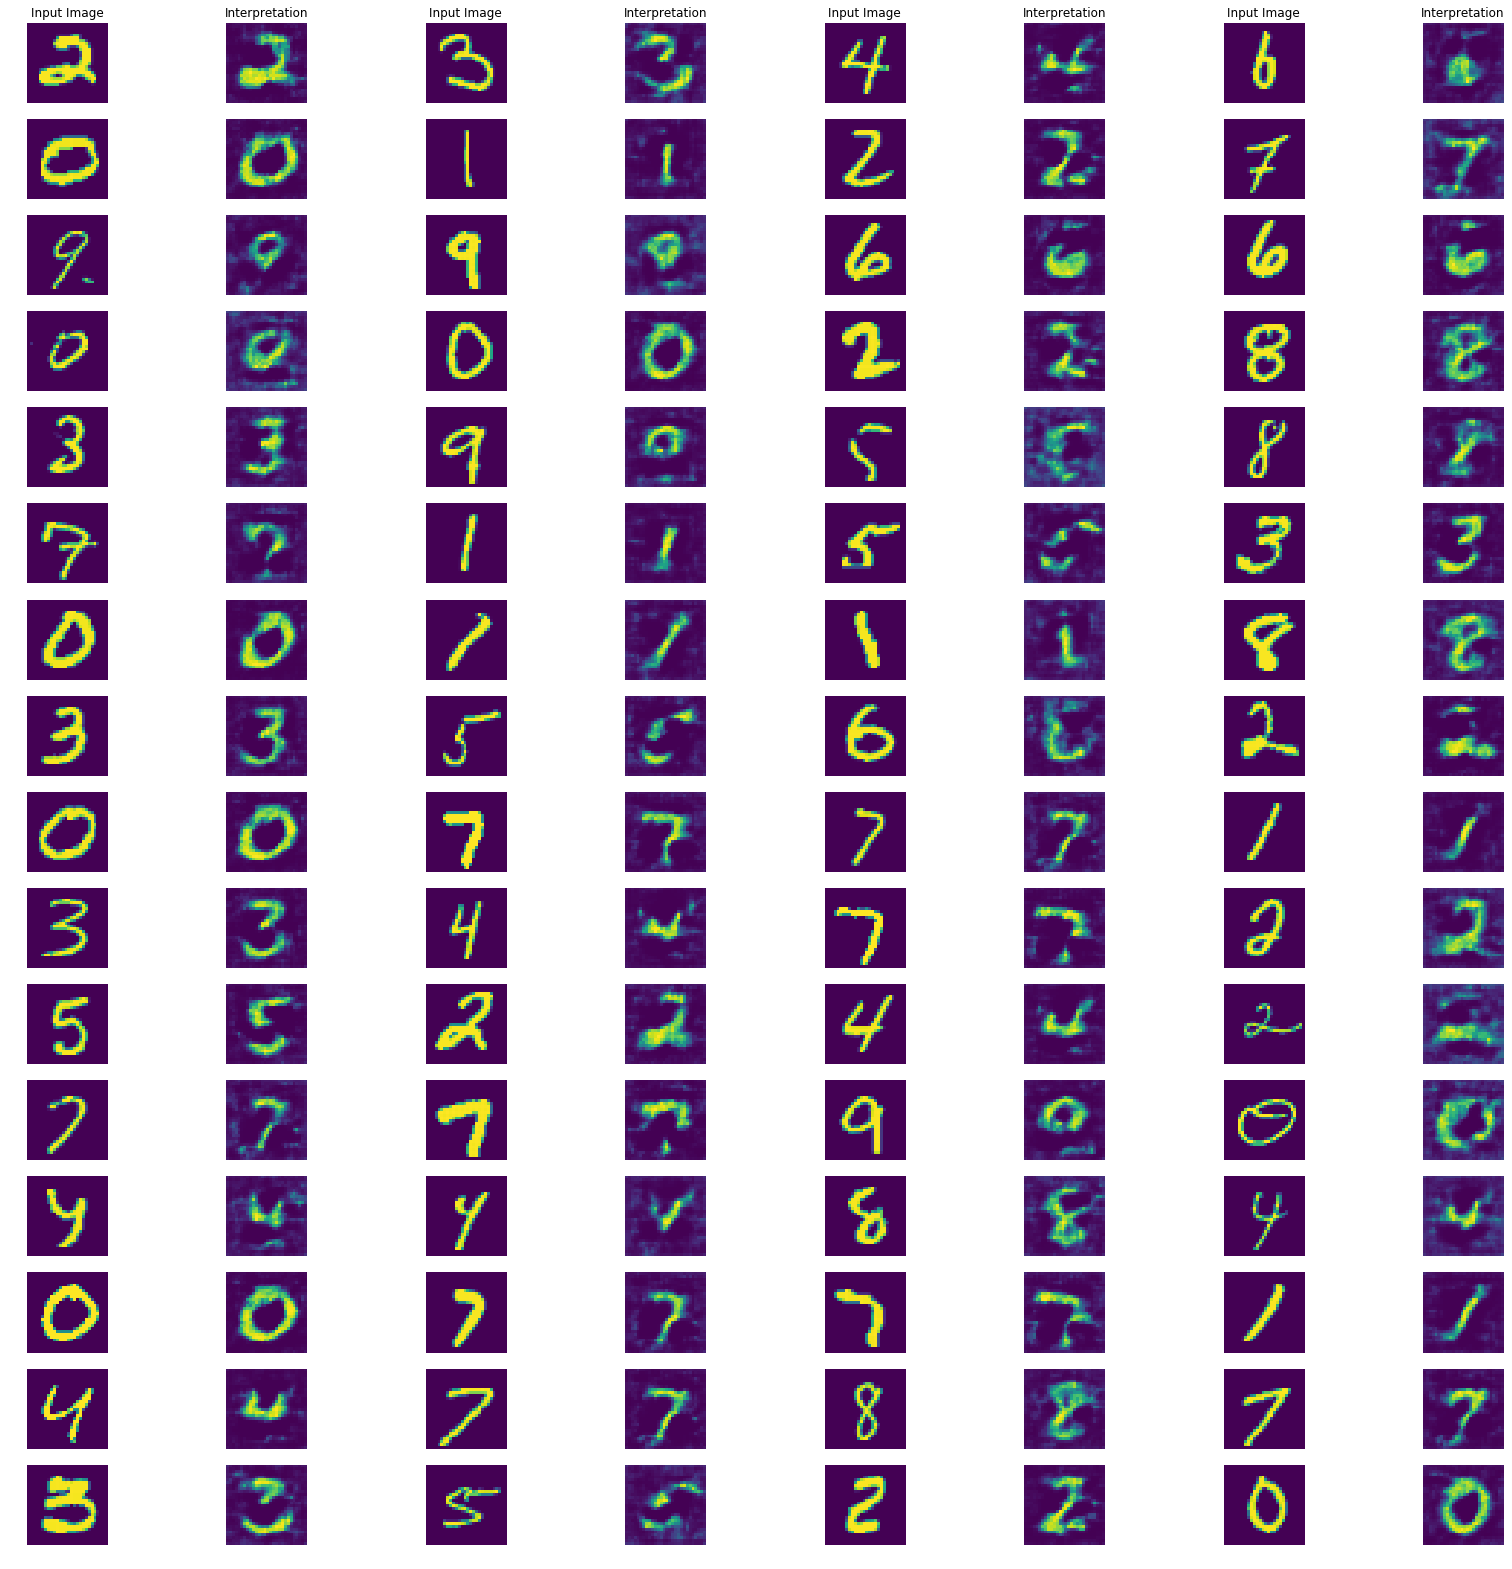

<Figure size 1440x1440 with 0 Axes>

In [4]:
import numpy as np
fig, axs = plt.subplots(16, 8, figsize=(28,28))
axs[0, 0].set_title('Input Image')
axs[0, 2].set_title('Input Image')
axs[0, 4].set_title('Input Image')
axs[0, 6].set_title('Input Image')
axs[0, 1].set_title('Interpretation')
axs[0, 3].set_title('Interpretation')
axs[0, 5].set_title('Interpretation')
axs[0, 7].set_title('Interpretation')

fig= plt.figure(figsize=(20, 20))

for j in range(0,4):
    for i in range(0,16):
        tests_figs = tests[i+j*16].reshape((28,28))
        axs[i, 2*j].imshow(tests_figs)
        axs[i, 2*j].axis('off')

        
for j in range(0,4):
    for i in range(0,16):
        interprets_figs = interprets[i+j*16].reshape((28,28))
        axs[i, 2*j+1].imshow(interprets_figs)
        axs[i, 2*j+1].axis('off')        
plt.show()